In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [2]:
adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_9AA_VisiumArray.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_visium_9AA.h5ad")

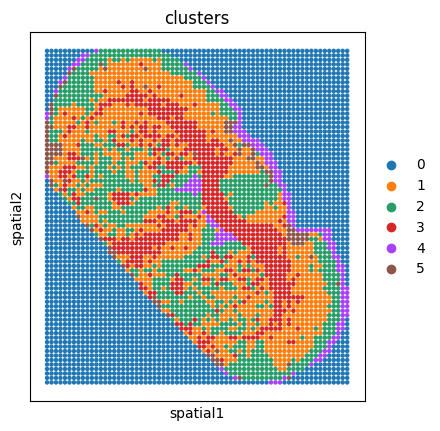

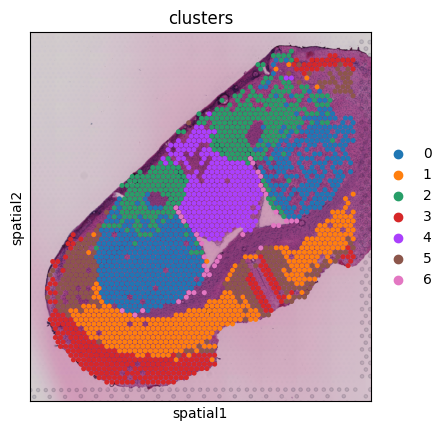

In [3]:
sc.pl.spatial(adata1, img_key = "hires", color="clusters", spot_size=1)
sc.pl.spatial(adata2, img_key = "hires", color="clusters", size=1.5)

In [8]:
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs["clusters"][adata1.obs["clusters"] == "0"]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]
print(adata2)
print(adata1)
print(idx_to_remove.index)

AnnData object with n_obs × n_vars = 2220 × 15630
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 3084 × 3658
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '5090', '5091', '5092', '5093', '5094', '5095', '5096', '5097', '5098',
       '5099'],
      dtype='object', 

[<Axes: title={'center': 'clusters'}, xlabel='spatial1', ylabel='spatial2'>]

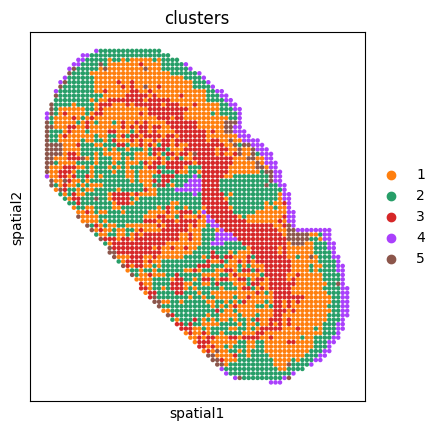

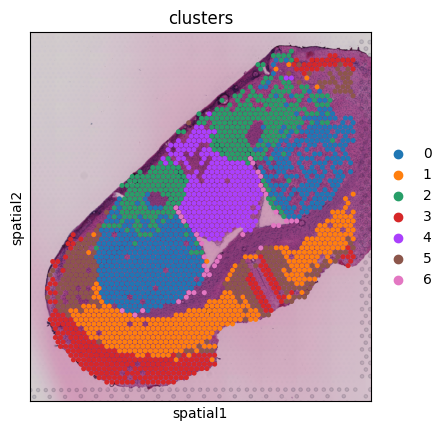

In [9]:
import matplotlib.pyplot as plt
sc.pl.spatial(adata1, img_key = "hires", color="clusters", spot_size=1, show=False)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_9AA_VisiumArray_plot.pdf")
sc.pl.spatial(adata2, img_key = "hires", color="clusters", size=1.5, show=False)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_visium_ctrl.pdf")

In [10]:
data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()

def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix

In [11]:
###casual run using neasrst indices
selected_indices = np.random.choice(range(3084), 2220, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[X1_label == 2] = 10
X1_label[X1_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, [10,11])] = 12
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[X3_label == 2] = 10
X3_label[X3_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, [10,11])] = 12

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 0] = 10
X2_label[X2_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label, [10,11])] = 12

[12 12 12 ... 10 10 12]


In [12]:
#####spatial alignment of data3(metabolic) and data2(spatial) using CCA
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_plus_x(row):
    new_x = row[1]
    new_y = row[0]
    return pd.Series({0: new_x, 1: new_y})

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-100, 100))
selected_indices = np.random.choice(range(3084), 2220, replace=False)
data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)

data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data1_spatial_results = data1_spatial_results +100
data2_spatial_results = data2_spatial_results +100
data3_spatial_results = data3_spatial_results +100

<bound method NDFrame.head of           0          1
0    -100.0 -62.162162
1    -100.0 -59.459459
2    -100.0 -56.756757
3    -100.0 -54.054054
4    -100.0 -51.351351
...     ...        ...
3079  100.0  48.648649
3080  100.0  51.351351
3081  100.0  54.054054
3082  100.0  56.756757
3083  100.0  59.459459

[3084 rows x 2 columns]>


In [54]:
data = data2_spatial_results
data["c"] = data2_leiden_str
data = data.rename(columns = {
    0:"x",
    1:"y",
    "c":"c"
})
data

x           y  c
0     157.979693  126.944860  1
1      18.502126  151.405215  5
2     144.412624   29.723231  2
3     179.814284  113.416328  1
4      33.567647  105.471255  5
...          ...         ... ..
2215  115.895745   75.673221  4
2216   57.155255  148.658901  0
2217   36.992681  154.082069  1
2218   31.901415  113.576619  5
2219   55.523735  189.180380  3

[2220 rows x 3 columns]

C:\Users\28123\AppData\Local\Temp\ipykernel_10052\4205888398.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


Text(0.5, 1.0, 'Image 1')

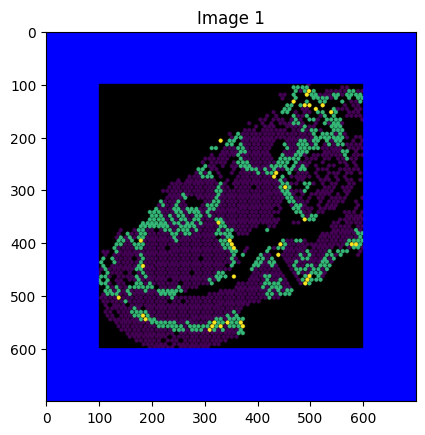

In [55]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from collections import Counter

# 示例数据框

df = pd.DataFrame(data)

# 设定n值
n = 2

# 建立KD树
tree = cKDTree(df[['x', 'y']])

# 计算Simpson index的函数
def simpson_index(c_values):
    counts = Counter(c_values)
    total = sum(counts.values())
    if total == 0:
        return 0
    return 1 - sum((count / total) ** 2 for count in counts.values())

# 存储结果的列表
results = []

# 遍历每个点
for i, row in df.iterrows():
    distances, indices = tree.query([row['x'], row['y']], k=n+1)
    c_values = df.iloc[indices]['c']
    D = simpson_index(c_values)
    E = len(set(c_values))
    results.append([row['x'], row['y'], row['c'], D, E])

# 创建结果数据框
result_df = pd.DataFrame(results, columns=['x', 'y', 'c', 'D', 'E'])


# 显示结果数据框
result_df
result_df.iloc[:,0:2]
img1 = create_image_from_data(data2_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=result_df['D'], border_color=(255, 0, 0), colormap='viridis')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

In [45]:
data = data3_spatial_results
data["c"] = data1_leiden_str
data = data.rename(columns = {
    0:"x",
    1:"y",
    "c":"c"
})
data

x      y  c
0     162.162162    0.0  4
1     159.459459    0.0  4
2     156.756757    0.0  5
3     154.054054    0.0  5
4     151.351351    0.0  5
...          ...    ... ..
3079   51.351351  200.0  4
3080   48.648649  200.0  4
3081   45.945946  200.0  4
3082   43.243243  200.0  4
3083   40.540541  200.0  4

[3084 rows x 3 columns]

C:\Users\28123\AppData\Local\Temp\ipykernel_10052\4205888398.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


Text(0.5, 1.0, 'Image 1')

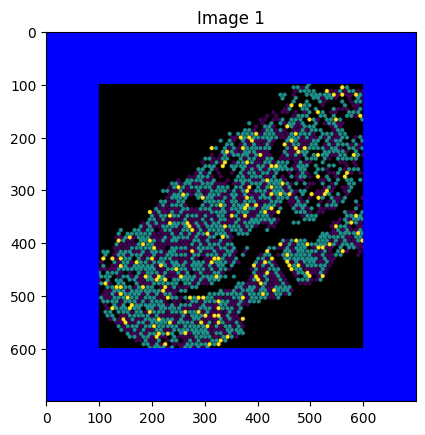

In [53]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from collections import Counter

# 示例数据框

df = pd.DataFrame(data)

# 设定n值
n = 2

# 建立KD树
tree = cKDTree(df[['x', 'y']])

# 计算Simpson index的函数
def simpson_index(c_values):
    counts = Counter(c_values)
    total = sum(counts.values())
    if total == 0:
        return 0
    return 1 - sum((count / total) ** 2 for count in counts.values())

# 存储结果的列表
results = []

# 遍历每个点
for i, row in df.iterrows():
    distances, indices = tree.query([row['x'], row['y']], k=n+1)
    c_values = df.iloc[indices]['c']
    D = simpson_index(c_values)
    E = len(set(c_values))
    results.append([row['x'], row['y'], row['c'], D, E])

# 创建结果数据框
result_df = pd.DataFrame(results, columns=['x', 'y', 'c', 'D', 'E'])


# 显示结果数据框
result_df
result_df.iloc[:,0:2]
img1 = create_image_from_data(data2_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=result_df['E'], border_color=(255, 0, 0), colormap='viridis')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

C:\Users\28123\AppData\Local\Temp\ipykernel_10052\4205888398.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


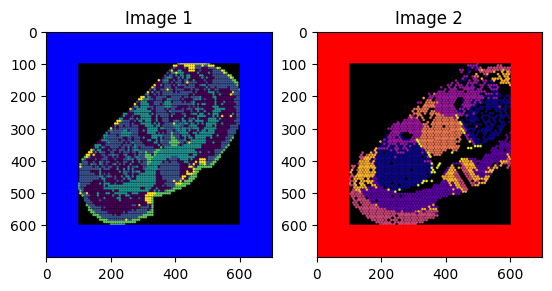

KeyboardInterrupt: 

In [30]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def create_image_from_data(data, width=500, height=500, dot_size=5, border_size=50, dot_colors=None, border_color=(0, 0, 0), colormap='viridis'):
    """
    Create an image from 2D data points with specified dot size, border size, and colors.

    Parameters:
    - data: 2D numpy array where data[0] contains x coordinates and data[1] contains y coordinates
    - width: Width of the image
    - height: Height of the image
    - dot_size: Size of the dots
    - border_size: Size of the border around the image
    - dot_colors: List of scalar values for each dot, which will be mapped to colors using a colormap
    - border_color: Color of the border (BGR format)
    - colormap: Colormap to use for mapping scalar values to colors
    
    Returns:
    - bordered_image: Image with data points and border
    """
    # Initialize an empty image with three channels for color
    image = np.zeros((height, width, 3), dtype=np.uint8)

    # Normalize data points to image dimensions
    x_norm = np.interp(data[0], (data[0].min(), data[0].max()), (0, width-1))
    y_norm = np.interp(data[1], (data[1].min(), data[1].max()), (0, height-1))

    # Normalize dot_colors to [0, 1] range
    if dot_colors is not None:
        norm = plt.Normalize(vmin=min(dot_colors), vmax=max(dot_colors))
        cmap = cm.get_cmap(colormap)
        mapped_colors = cmap(norm(dot_colors))

    # Draw circles at normalized positions
    for i, (x, y) in enumerate(zip(x_norm, y_norm)):
        if dot_colors is not None:
            color = (mapped_colors[i][:3] * 255).astype(int)  # Convert to BGR format
            color = tuple(map(int, color[::-1]))  # Convert from RGB to BGR
        else:
            color = (255, 255, 255)  # Default white color
        cv2.circle(image, (int(x), int(y)), dot_size, color, -1)  # -1 means filled circle

    # Add border
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, 
                                        cv2.BORDER_CONSTANT, value=border_color)

    return bordered_image

# Simulated scalar values
dot_colors_1 = data1_leiden_str.astype(int)
dot_colors_2 = data2_leiden_str.astype(int)

# Create images
img1 = create_image_from_data(data3_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=dot_colors_1, border_color=(255, 0, 0), colormap='viridis')
img2 = create_image_from_data(data2_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=dot_colors_2, border_color=(0, 0, 255), colormap='plasma')

# Display images using matplotlib
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')

plt.show()


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lists to store points
points_image1 = []
points_image2 = []

def click_event_image1(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image1.append((x, y))
        cv2.circle(img1_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 1', img1_display)

def click_event_image2(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image2.append((x, y))
        cv2.circle(img2_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 2', img2_display)

def compute_affine_transform(points_image1, points_image2):
    pts1 = np.float32(points_image1)
    pts2 = np.float32(points_image2)
    M = cv2.getAffineTransform(pts2[:3], pts1[:3])  # Use the first 3 points for affine transform
    return M

def warp_image(image, M, output_shape):
    warped_image = cv2.warpAffine(image, M, output_shape)
    return warped_image


def adjust_alpha(image, alpha):
    """ Adjust the alpha (transparency) of an image. """
    overlay = np.zeros_like(image, dtype=np.uint8)
    return cv2.addWeighted(image, alpha, overlay, 1 - alpha, 0)

def blend_with_background(background, image, alpha):
    """ Blend the image with a background image based on alpha. """
    return cv2.addWeighted(image, alpha, background, 1 - alpha, 0)
    

# Load images
img1_display = img1.copy()
img2_display = img2.copy()


alpha = 0.7  # 透明度（0到1之间）

# 调整透明度
background = np.ones_like(img1_display, dtype=np.uint8) * 255  # 白色背景
img1_display = blend_with_background(background, img1_display, alpha)
background = np.ones_like(img2_display, dtype=np.uint8) * 255 
img2_display = blend_with_background(background, img2_display, alpha)

# Display images and set mouse callbacks
cv2.imshow('Image 1', img1_display)
cv2.imshow('Image 2', img2_display)
cv2.setMouseCallback('Image 1', click_event_image1)
cv2.setMouseCallback('Image 2', click_event_image2)

# Wait until 6 points are selected (3 from each image)
while len(points_image1) < 3 or len(points_image2) < 3:
    cv2.waitKey(1)

cv2.destroyAllWindows()

# Compute the transformation matrix
M = compute_affine_transform(points_image1, points_image2)
print("Transformation Matrix:\n", M)

# Apply the transformation to the second image
rows, cols = img1.shape[:2]
aligned_image = warp_image(img2, M, (cols, rows))

# Display the original and aligned images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image 2')
plt.show()

M_homogeneous = np.vstack([M, [0, 0, 1]])

# Convert DataFrame to homogeneous coordinates
coordinates_data3 = data3_spatial_results  # Add a column of 1s
coordinates_data2 = data2_spatial_results  # Add a column of 1s

# Apply the transformation matrix
#transformed_coordinates_data3 = coordinates_data3.dot(M_homogeneous.T)
transformed_coordinates_data2 = coordinates_data2.dot(M)
# Update the DataFrame with the transformed coordinates
print(transformed_coordinates_data2)
print(data3_spatial_results)
plt.title('Original Points')
plt.scatter(data3_spatial_results[0], data3_spatial_results[1], c=data1_leiden_str.astype(int), label='data3 Points',alpha=0.3,cmap='tab20')
plt.scatter(transformed_coordinates_data2[0], transformed_coordinates_data2[1], c=data2_leiden_str.astype(int), label='Original Points',alpha=0.3,cmap='tab20')
plt.legend()
plt.show

plt.title('Original Points')
plt.scatter(data3_spatial_results[0], data3_spatial_results[1], color = "red", alpha=0.3)
plt.scatter(transformed_coordinates_data2[0], transformed_coordinates_data2[1], color = "blue", alpha=0.3)
plt.legend()
plt.show


In [205]:
print(transformed_coordinates_data2)
data2_spatial_results = transformed_coordinates_data2.iloc[:,0:2]
print(data2_spatial_results)

               0           1            2
0     137.230094  124.255017   273.778642
1      21.568259  146.357159 -1060.195023
2     121.970208   30.256630   940.797906
3     154.945995  111.431878   560.198184
4      32.318654  102.178616  -569.785765
...          ...         ...          ...
2215   99.970954   74.304992   340.481751
2216   53.783703  144.124593  -722.771066
2217   37.139849  149.141443  -930.704652
2218   31.251444  109.984968  -648.224505
2219   54.050420  183.223745 -1060.245167

[2220 rows x 3 columns]
               0           1
0     137.230094  124.255017
1      21.568259  146.357159
2     121.970208   30.256630
3     154.945995  111.431878
4      32.318654  102.178616
...          ...         ...
2215   99.970954   74.304992
2216   53.783703  144.124593
2217   37.139849  149.141443
2218   31.251444  109.984968
2219   54.050420  183.223745

[2220 rows x 2 columns]


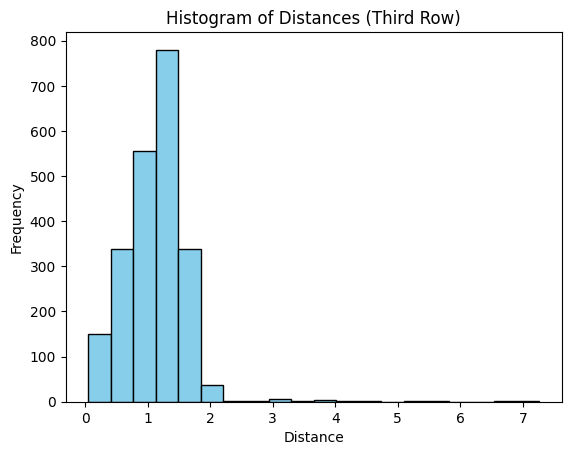

C:\Users\28123\AppData\Local\Temp\ipykernel_16980\2749292034.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\28123\AppData\Local\Temp\ipykernel_16980\2749292034.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3439,) (3439,)
(2150,)
(2198,)
               0         1
1373  133.397351  1.727190
1752  157.402226  4.615509
1993  154.591059  4.579111
374   132.102803  4.313715
1373  133.397351  1.727190
             0         1
11  132.432432  0.000000
19  156.756757  2.985075
20  154.054054  2.985075
28  132.432432  2.985075
28  132.432432  2.985075
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z
0     133.397351       1.727190        1373                2             -1
1     157.402226       4.615509        1752                3             -1
2     154.591059       4.579111        1993                3             -1
3     132.102803       4.313715         374                2             -1
4     133.397351       1.727190        1373                2             -1
   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       132.432432         0.000000            11                  5   
1       156.756757         2.985075            19       

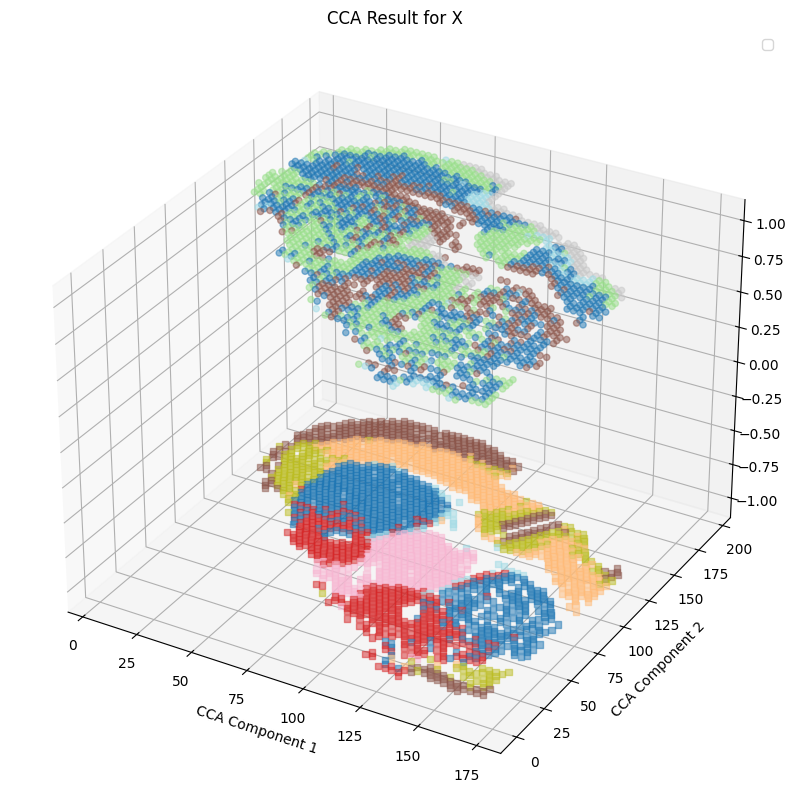

In [255]:
####select nearst neighbour groups of sample pairs between X1 and X3
####
X_c=pd.DataFrame(data1_spatial_results)
Y_c=pd.DataFrame(data2_spatial_results)
Z_c=pd.DataFrame(data3_spatial_results)
dist_min = 2 ## min euclidean distance
from scipy.spatial.distance import cdist
distances = cdist(data3_spatial_results, data2_spatial_results, metric='euclidean')
dist_df = pd.DataFrame(distances)
dt_describe = dist_df.describe()
plt.hist(dt_describe.iloc[3,], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances (Third Row)')
plt.show()
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
row_indices, col_indices = np.where(distances <dist_min)
unique_row_indices = np.unique(row_indices)
unique_col_indices = np.unique(col_indices)
#############plot
####Z_C is metablic and is at 1
print(row_indices.shape, col_indices.shape)
print(unique_row_indices.shape)
print(unique_col_indices.shape)
print(Y_c.iloc[col_indices,].head())
print(Z_c.iloc[row_indices,].head())
Y_C_=Y_c.iloc[col_indices,]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_=Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str[col_indices].astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_=Y_C_.drop(columns=['index'])
Y_C_=Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})

Z_C_=Z_c.iloc[row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})

print(Y_C_.head())
print(Z_C_.head())
pairs = pd.concat([Y_C_,Z_C_],axis=1)
pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()


In [256]:
import pandas as pd

def calculate_simpson_index(values):
    total_count = len(values)
    unique_values = set(values)
    simpson_index = 1 - sum((values.count(value) / total_count) ** 2 for value in unique_values)
    return simpson_index

def main(df):
    # 保存每个 X1 中值对应的 X2 中值的列表
    x1_x2_lists = df.groupby('spatial_ID')['matabolic_cluster'].apply(list).reset_index()

    # 计算每个 X1 中值的辛普森指数
    simpson_indices = x1_x2_lists['matabolic_cluster'].apply(calculate_simpson_index)

    # 保存每个 X1 中值对应的 X2 中出现频率最高的值
    max_x2_values = x1_x2_lists['matabolic_cluster'].apply(lambda x: max(set(x), key=x.count))

    # 生成新的 DataFrame
    new_df = pd.DataFrame({'spatial_ID': x1_x2_lists['spatial_ID'], 'Most_freq_metabolic_cluster': max_x2_values, 'Simpson_Index': simpson_indices})

    # 合并 X3 列
    new_df = pd.merge(new_df, df[['spatial_ID',"spatial_cluster"]].drop_duplicates(), on='spatial_ID', how='left')

    return new_df

# 示例输入数据
data = pairs
df = pd.DataFrame(data)

# 调用主函数
result_df = main(df)
print("新的 DataFrame:")
print(result_df)


新的 DataFrame:
      spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0              0                            1            0.5                1
1              1                            1            0.0                5
2              2                            2            0.0                2
3              3                            1            0.0                1
4              4                            1            0.0                5
...          ...                          ...            ...              ...
2193        2215                            3            0.0                4
2194        2216                            1            0.0                0
2195        2217                            3            0.0                1
2196        2218                            2            0.0                5
2197        2219                            1            0.0                3

[2198 rows x 4 columns]


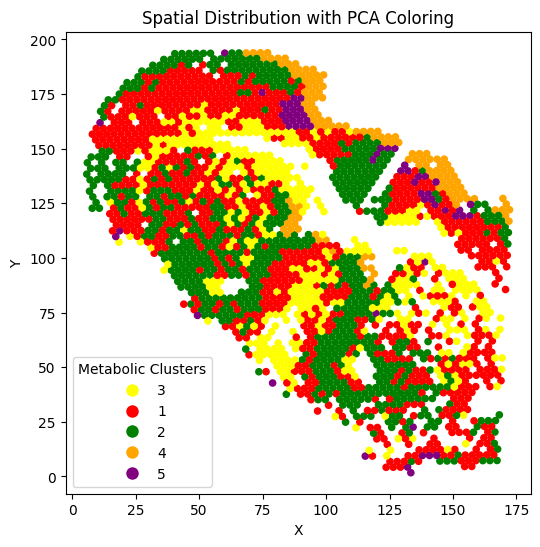

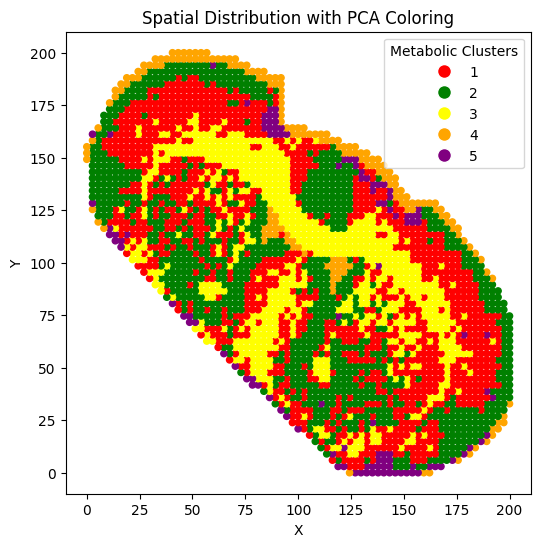

In [252]:
plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 0],data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 1],
            c=[color_mapping[category] for category in result_df[result_df["Simpson_Index"]<1]["Most_freq_metabolic_cluster"].tolist()], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = result_df["Most_freq_metabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\groundtruth.pdf")
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
unique_categories = np.unique(data1_leiden_str.astype(int))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
plt.title('Spatial Distribution with PCA Coloring')
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\metabolic__.pdf")
plt.show()

C:\Users\28123\AppData\Local\Temp\ipykernel_16980\2447038678.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3084, 2) (2220, 2)
(3084, 2220)
(3084, 2) (2220, 2)
(3084, 2) (2220, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0     137.230094     124.255017           0                1             -1   
1      21.568259     146.357159           1                5             -1   
2     121.970208      30.256630           2                2             -1   
3     154.945995     111.431878           3                1             -1   
4      32.318654     102.178616           4                5             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       137.837838       125.373134          2068                  3   
1        21.621622       146.268657          2496                  1   
2       121.621622        29.850746           316                  2   
3       154.054054       110.447761          1754                  1   
4        32.432432       101.492537          1616                  1   

   matabolic.CCA.Z 

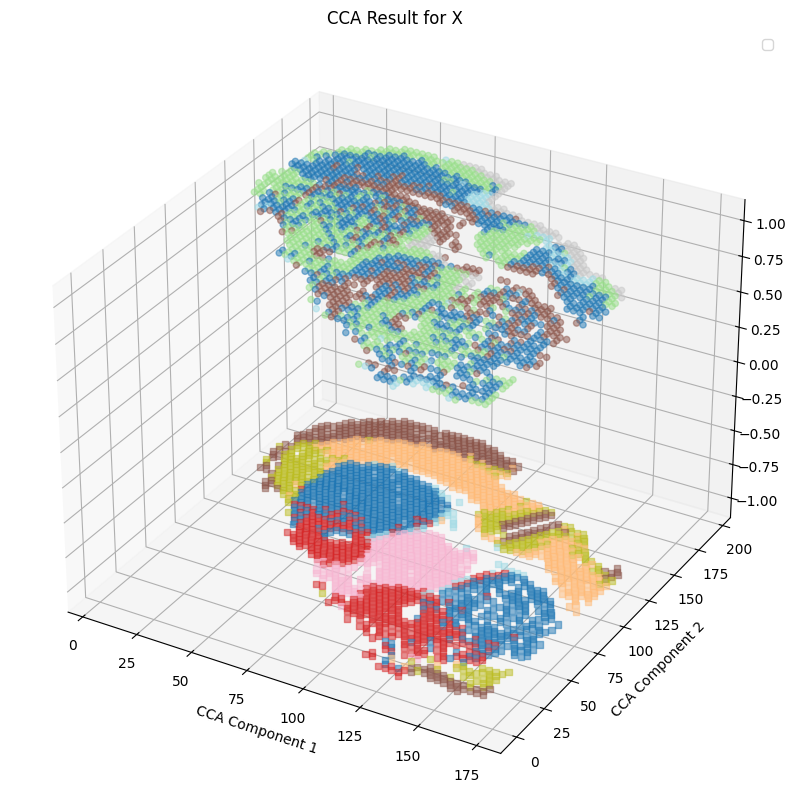

In [253]:
Y_c = data2_spatial_results
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(data3_spatial_results, data2_spatial_results, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

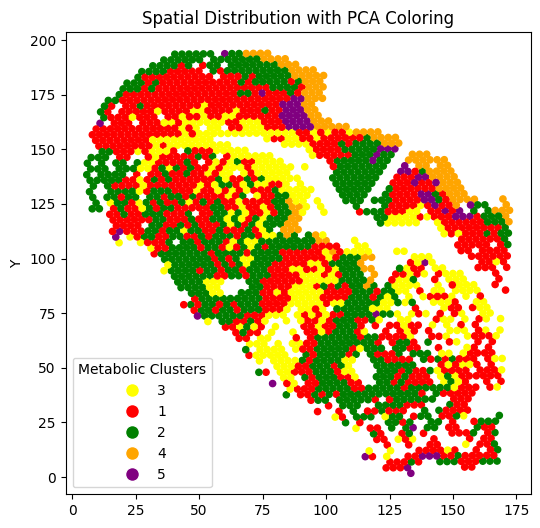

In [247]:
plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\no_anchor_merge_nearst_pair.pdf")
plt.show()


In [248]:
result_df

spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0              0                            1            0.5                1
1              1                            1            0.0                5
2              2                            2            0.0                2
3              3                            1            0.0                1
4              4                            1            0.0                5
...          ...                          ...            ...              ...
2193        2215                            3            0.0                4
2194        2216                            1            0.0                0
2195        2217                            3            0.0                1
2196        2218                            2            0.0                5
2197        2219                            1            0.0                3

[2198 rows x 4 columns]

<bound method NDFrame.head of       spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0              0                            1            0.5                1
1              1                            1            0.0                5
2              2                            2            0.0                2
3              3                            1            0.0                1
4              4                            1            0.0                5
...          ...                          ...            ...              ...
2193        2215                            3            0.0                4
2194        2216                            1            0.0                0
2195        2217                            3            0.0                1
2196        2218                            2            0.0                5
2197        2219                            1            0.0                3

[2198 rows x 4 columns]>
      sp

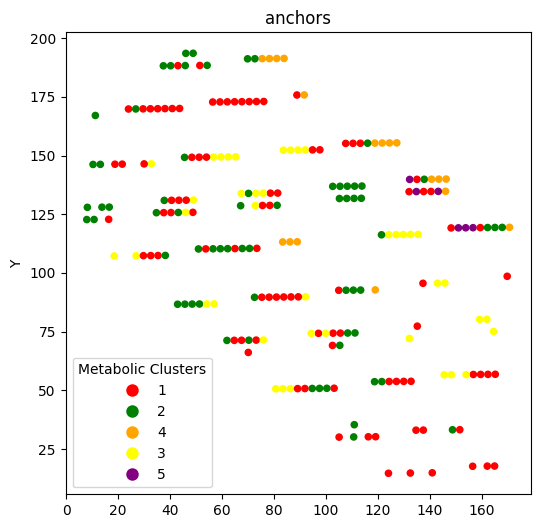

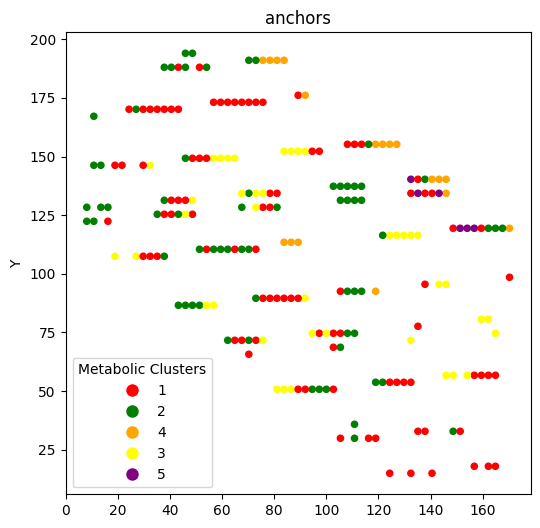

In [257]:
###### find transcript-metaboic pairs anchors by filtering: 
######1/simpson index less than 0.2 2/Most_freq_metabolic_cluster==matabolic_cluster
print(result_df.head)
#print(pairs.head)
merged_df = pd.merge(result_df, pairs, on='spatial_ID', how='inner')
merged_df = pd.DataFrame(merged_df)
print(merged_df)
merged_df = merged_df[(merged_df['Simpson_Index'] < 0.001) & (merged_df['Most_freq_metabolic_cluster'] == merged_df['matabolic_cluster'])&(merged_df['distance'] < 0.5) ]
merged_df = merged_df.drop_duplicates(subset="matabolic_ID")
print(merged_df["spatial_ID"])

plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[merged_df["spatial_ID"], 0],data2_spatial_results.iloc[merged_df["spatial_ID"], 1], 
            c=[color_mapping[category] for category in merged_df["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('anchors')
unique_categories = merged_df["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\anchor_spatial.pdf")
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(data3_spatial_results.iloc[merged_df["matabolic_ID"], 0],data3_spatial_results.iloc[merged_df["matabolic_ID"], 1], 
            c=[color_mapping[category] for category in merged_df["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('anchors')
unique_categories = merged_df["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\anchor_metabolic.pdf")
plt.show()


In [216]:
scaler = MinMaxScaler(feature_range=(-1, 1))
DF1 = convert_to_array(adata2.X)
DF1 = pd.DataFrame(DF1)
DF1 = tpm_normalize(DF1)
DF1 = np.log2(DF1 + 1)
DF1 = scaler.fit_transform(DF1)
DF1 = pd.DataFrame(DF1)

DF2 = convert_to_array(adata1.X)
DF2 = pd.DataFrame(DF2)
DF2 = scaler.fit_transform(DF2)
DF2 = pd.DataFrame(DF2)

print(DF1.shape,DF2.shape)
spatial_ID_list = merged_df['spatial_ID'].tolist()
metabolic_ID_list = merged_df['matabolic_ID'].tolist()

# 从 DF1 和 DF2 中提取对应的样本
spatial_samples = DF1.loc[spatial_ID_list,:]
index_strings = adata2.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(spatial_samples.columns, index_strings)}
spatial_samples.rename(columns=column_mapping, inplace=True)
rowindex = spatial_samples.shape[0]
spatial_samples.index = range(rowindex)

metabolic_samples = DF2.loc[metabolic_ID_list,:]
rowindex = metabolic_samples.shape[0]
index_strings = adata1.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(metabolic_samples.columns, index_strings)}
metabolic_samples.rename(columns=column_mapping, inplace=True)
metabolic_samples.index = range(rowindex)

print(spatial_samples.shape,metabolic_samples.shape,pd.concat([spatial_samples, metabolic_samples], axis=0).shape)
# 计算特征之间的相关性

(2220, 15630) (3084, 3658)
(224, 15630) (224, 3658) (448, 19288)


In [217]:
correlation_matrix = pd.concat([spatial_samples, metabolic_samples], axis=1)
correlation_matrix = correlation_matrix.corr()
# 显示相关性矩阵
print("DF1 列变量与 DF2 列变量之间的相关性矩阵：")

# 显示 DF3
#print(DF3)

DF1 列变量与 DF2 列变量之间的相关性矩阵：


(15630, 3658)


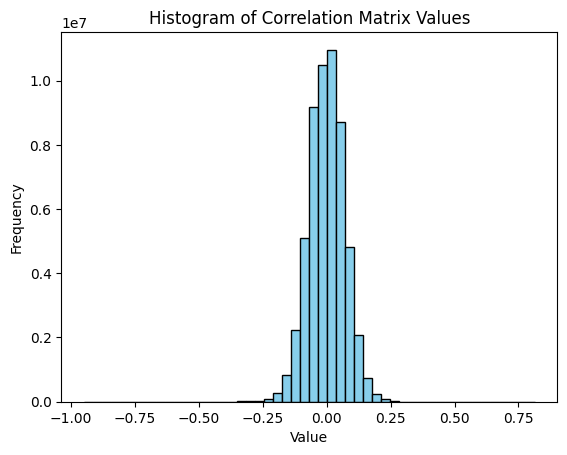

In [218]:
correlation_matrix2 = correlation_matrix.iloc[:15630, -3658:]
print(correlation_matrix2.shape)

values = correlation_matrix2.values.flatten()
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()
high_correlation_spatial = []
high_correlation_metabolic = []



In [219]:
import pandas as pd
import numpy as np

# Example correlation matrix with NaN values

# Flatten the correlation matrix and keep track of the row and column indices, excluding NaNs
flattened = correlation_matrix2.values.flatten()
non_nan_indices = ~np.isnan(flattened)
flattened_non_nan = flattened[non_nan_indices]
original_indices = np.dstack(np.unravel_index(np.where(non_nan_indices)[0], correlation_matrix2.shape))[0]

# Sort the non-NaN flattened array to find the top 20 highest values
sorted_indices = np.argsort(flattened_non_nan)[::-1]
top_n = 30
top_indices = original_indices[sorted_indices[:top_n]]

# Retrieve the corresponding row and column indices
top_rows = top_indices[:, 0]
top_cols = top_indices[:, 1]

# Get the top 20 highest values
top_values = flattened_non_nan[sorted_indices[:top_n]]

# Convert to lists if needed
top_rows = list(top_rows)
top_cols = list(top_cols)
top_values = list(top_values)

# Display results
print("Top 20 highest correlation values (excluding NaNs):")
for i in range(len(top_values)):
    print(f"Value: {top_values[i]}, Row: {top_rows[i]}, Column: {top_cols[i]}")

# Optionally, convert to a DataFrame for easier viewing
top_correlations_df = pd.DataFrame({
    'Value': top_values,
    'Row': top_rows,
    'Column': top_cols
})

print("\nTop 20 highest correlation values in DataFrame format:")
print(top_correlations_df)


Top 20 highest correlation values (excluding NaNs):
Value: 0.8136617867098194, Row: 8346, Column: 2637
Value: 0.650818706818501, Row: 4700, Column: 686
Value: 0.6496172724368244, Row: 13305, Column: 728
Value: 0.6415347222934451, Row: 13305, Column: 727
Value: 0.6400579375730122, Row: 8904, Column: 2752
Value: 0.6293607015511852, Row: 13305, Column: 1336
Value: 0.6223722649931895, Row: 10945, Column: 2583
Value: 0.6117512714207917, Row: 13438, Column: 2637
Value: 0.6117512714207914, Row: 2933, Column: 2637
Value: 0.6117512714207914, Row: 6859, Column: 2637
Value: 0.6117512714207913, Row: 9512, Column: 2637
Value: 0.6117512714207912, Row: 12457, Column: 2637
Value: 0.5990062028188187, Row: 7660, Column: 2637
Value: 0.5952218654081652, Row: 8904, Column: 894
Value: 0.5900489652077099, Row: 13305, Column: 1333
Value: 0.5849842865647378, Row: 8904, Column: 909
Value: 0.5843591575029732, Row: 4700, Column: 1537
Value: 0.579845491196565, Row: 3505, Column: 32
Value: 0.5759901043249352, Row: 

(2, 224) (2, 224) (32, 224) (32, 224)
[1, 21, 24, 29, 49, 88, 112, 113, 116, 120, 128, 150, 162, 178, 191, 198, 209, 212, 220, 221, 243, 263, 272, 273, 275, 293, 294, 309, 312, 316, 318, 330, 334, 338, 349, 350, 356, 360, 369, 384, 385, 388, 397, 404, 408, 419, 425, 430, 431, 451, 456, 477, 478, 487, 491, 499, 501, 502, 507, 524, 528, 530, 532, 545, 551, 560, 561, 573, 585, 596, 602, 604, 609, 620, 626, 630, 663, 684, 706, 724, 735, 737, 742, 763, 792, 797, 800, 806, 846, 848, 853, 877, 885, 907, 910, 912, 917, 945, 962, 963, 967, 980, 996, 997, 1000, 1001, 1006, 1016, 1019, 1036, 1043, 1045, 1053, 1062, 1076, 1077, 1078, 1087, 1094, 1097, 1109, 1112, 1119, 1124, 1128, 1134, 1145, 1147, 1150, 1173, 1175, 1177, 1179, 1187, 1190, 1226, 1228, 1236, 1248, 1252, 1268, 1273, 1280, 1282, 1290, 1312, 1320, 1335, 1346, 1353, 1369, 1372, 1430, 1508, 1521, 1533, 1549, 1562, 1569, 1587, 1600, 1602, 1603, 1604, 1613, 1635, 1659, 1669, 1704, 1707, 1713, 1727, 1742, 1746, 1758, 1786, 1822, 1839, 1853

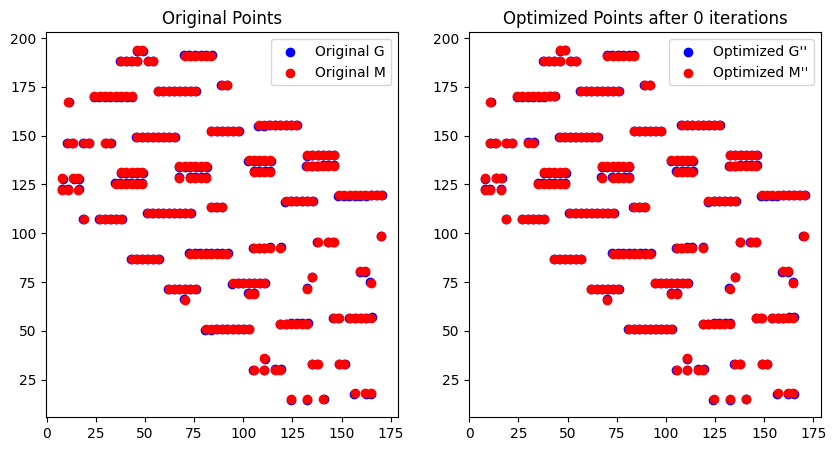

Iteration 0: Euclidean distance between G and M: 5.305752884350931


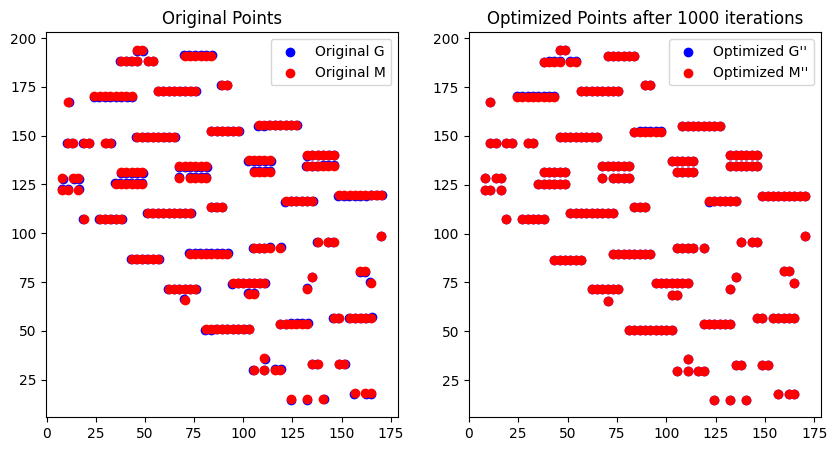

Iteration 1000: Euclidean distance between G and M: 0.9911121743591326


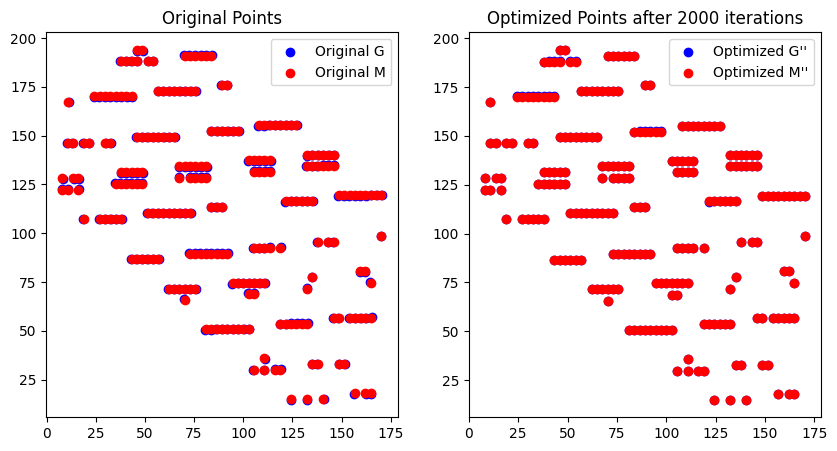

Iteration 2000: Euclidean distance between G and M: 0.9909897707690414


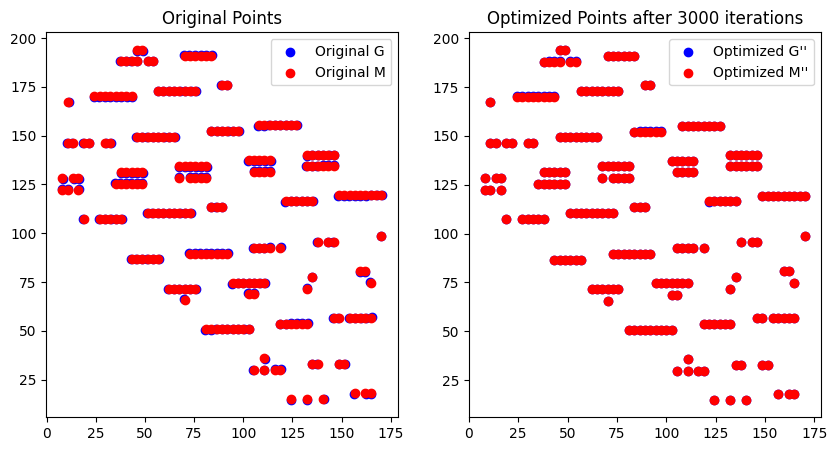

Iteration 3000: Euclidean distance between G and M: 0.9908644764433968


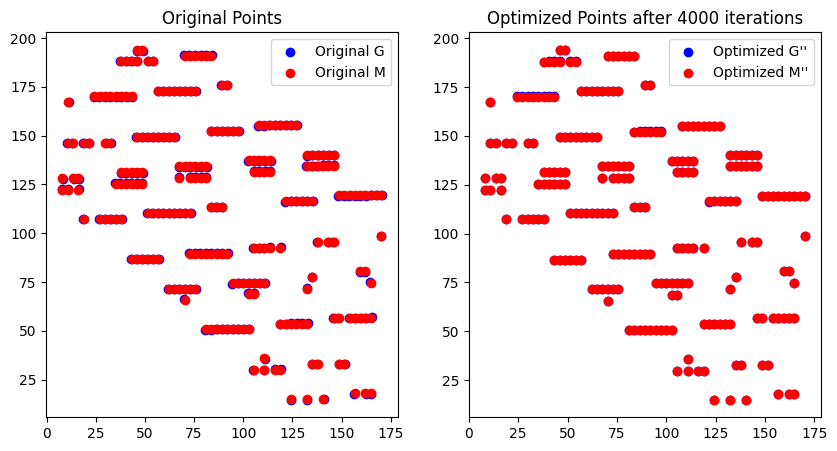

Iteration 4000: Euclidean distance between G and M: 0.9907440487287761


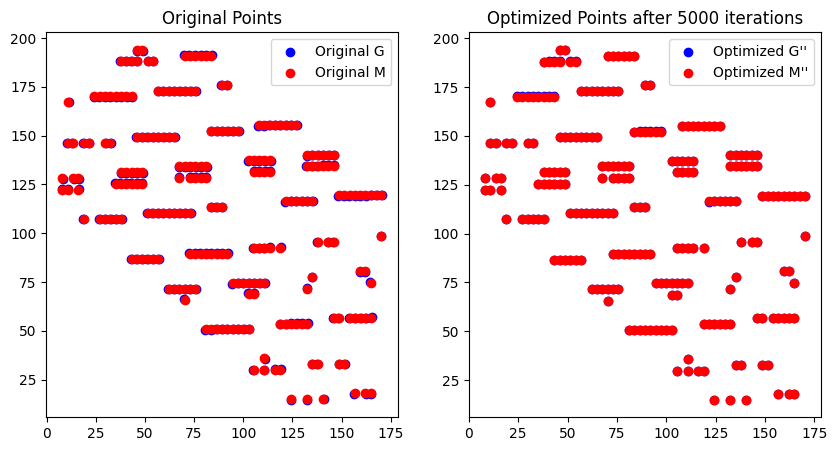

Iteration 5000: Euclidean distance between G and M: 0.9906284492973356


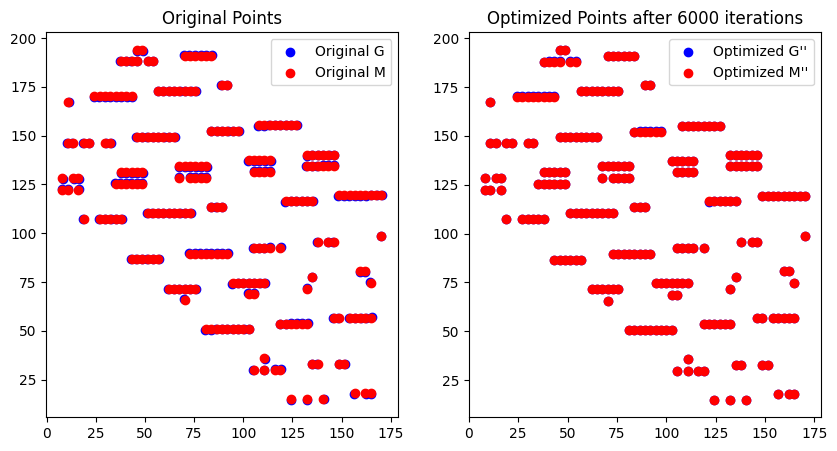

Iteration 6000: Euclidean distance between G and M: 0.9905174473046421


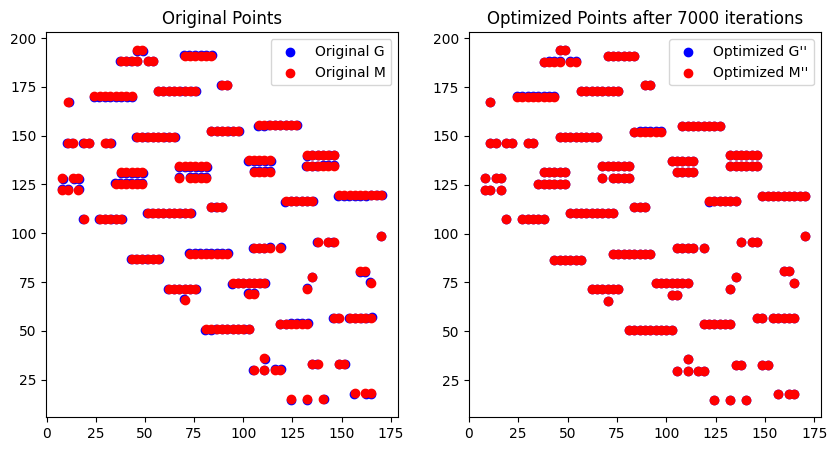

Iteration 7000: Euclidean distance between G and M: 0.9904108234287529


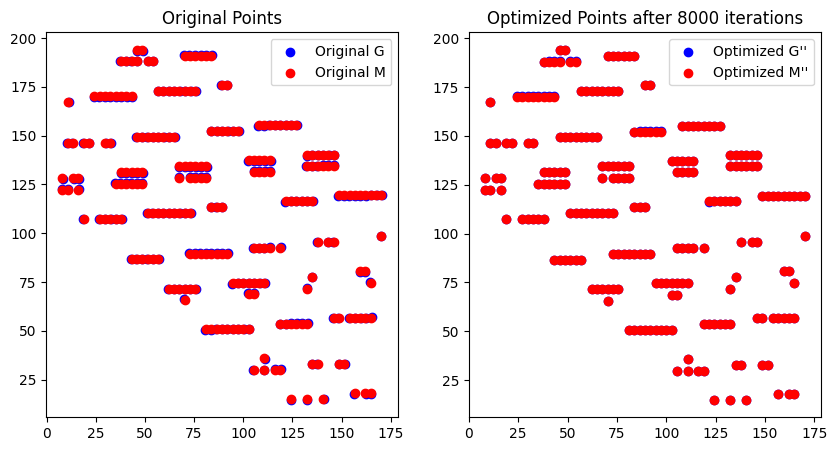

Iteration 8000: Euclidean distance between G and M: 0.9903083706805332


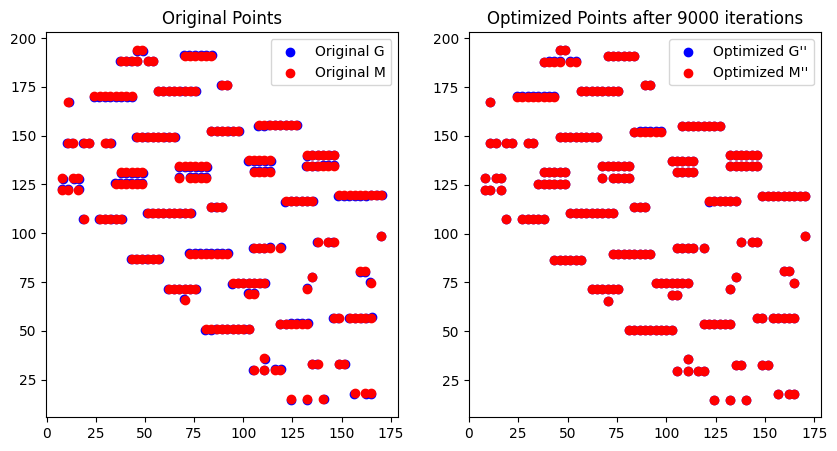

Iteration 9000: Euclidean distance between G and M: 0.9902098936273946
: Euclidean distance between G' and M': 27.197588897375734
优化后的 f_G:
[[-9.96799900e-01  8.15672961e-03  3.52577796e-04  0.00000000e+00
   1.55356017e-02  0.00000000e+00  1.84638185e-04  0.00000000e+00
   0.00000000e+00  5.81552665e-02  4.74574968e-02 -3.89386179e-02
  -6.04538241e-02  4.27225410e-02 -5.85698263e-03  0.00000000e+00
   2.74228376e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.83280387e-02  0.00000000e+00  5.20575616e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.23538867e-02  0.00000000e+00
  -1.53377500e-01  1.73246755e-01  0.00000000e+00  2.18110208e-03]
 [-6.30000448e-05 -9.84162103e-01  1.27818306e-03  8.69558770e-03
   1.20167902e-02  1.30731544e-02  1.06757819e-02  0.00000000e+00
   8.68174736e-03 -3.56177784e-02 -2.76881733e-02  3.63520047e-02
   5.22999167e-02 -2.41784390e-02 -4.55187443e-03  2.26517619e-03
   3.58669392e-02  3.19662234e-03  0.00000000e+00  0.00000000e+00
 

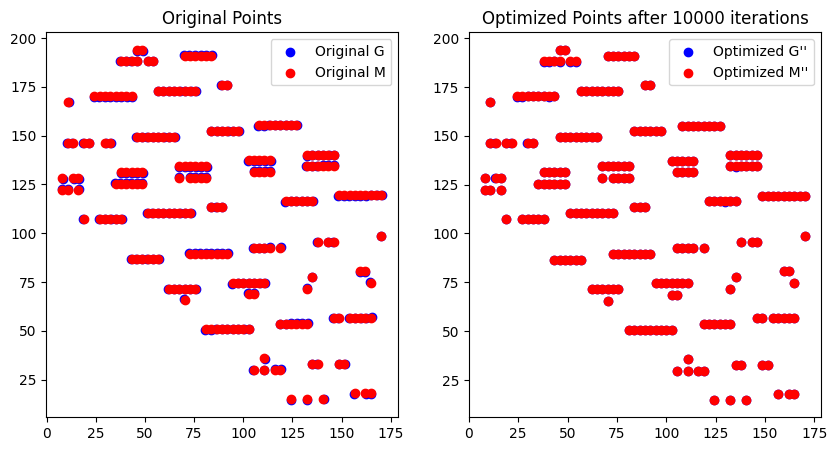

In [220]:
import numpy as np
import matplotlib.pyplot as plt
scaler = MinMaxScaler(feature_range=(-1, 1))
metabolic_select_high_corr_variant = convert_to_array(adata1.X)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = scaler.fit_transform(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = metabolic_select_high_corr_variant.iloc[:,top_cols]
metabolic_select_high_corr_variant = pd.concat([data3_spatial_results, metabolic_select_high_corr_variant], axis=1)

spatial_select_high_corr_variant = convert_to_array(adata2.X)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = scaler.fit_transform(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = spatial_select_high_corr_variant.iloc[:,top_rows]
spatial_select_high_corr_variant = pd.concat([data2_spatial_results, spatial_select_high_corr_variant], axis=1)


# 假设G和M是已知的2xM矩阵
G = data2_spatial_results.T.iloc[:,spatial_ID_list].to_numpy()  # 示例数据
M = data3_spatial_results.T.iloc[:,metabolic_ID_list].to_numpy() # 示例数据

# 假设G'和M'是已知的nxM矩阵
G_prime = spatial_select_high_corr_variant.T.iloc[:,spatial_ID_list].to_numpy()  # 示例数据
M_prime = metabolic_select_high_corr_variant.T.iloc[:,metabolic_ID_list].to_numpy()  # 示例数据
print(G.shape, M.shape, G_prime.shape,M_prime.shape)
print(spatial_ID_list)
print(metabolic_ID_list)
# 初始化f_G和f_M为零矩阵
# 初始化f_G和f_M为零矩阵
f_G = np.zeros((G.shape[0], G_prime.shape[0]))
f_M = np.zeros((M.shape[0], M_prime.shape[0]))

# 定义学习率和迭代次数
alpha = 0.01
iterations = 10000
clip_value = 1.0  # 梯度裁剪阈值

# 目标函数的梯度计算
def compute_gradients(G, M, G_prime, M_prime, f_G):
    G_double_prime = G + f_G.dot(G_prime-M_prime)
    M_double_prime = M
    diff = G_double_prime - M_double_prime
    d_G = 2 * diff.dot(G_prime.T-M_prime.T)
    return d_G

def euclidean_distance(G, M):
    squared_diff = np.square(G - M)
    sum_squared_diff = np.sum(squared_diff)
    distance = np.sqrt(sum_squared_diff)
    return distance

# 可视化函数
def plot_matrices(G, M, G_double_prime, M_double_prime, iteration):
    plt.figure(figsize=(10, 5))

    # 原始点和优化后的点
    plt.subplot(1, 2, 1)
    plt.scatter(G[0, :], G[1, :], color='blue', label='Original G')
    plt.scatter(M[0, :], M[1, :], color='red', label='Original M')
    plt.title('Original Points')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(G_double_prime[0, :], G_double_prime[1, :], color='blue', label='Optimized G\'\'')
    plt.scatter(M_double_prime[0, :], M_double_prime[1, :], color='red', label='Optimized M\'\'')
    plt.title(f'Optimized Points after {iteration} iterations')
    plt.legend()

    plt.show()


# 迭代优化
for i in range(iterations):
    d_G = compute_gradients(G, M, G_prime, M_prime, f_G)
    
    # 梯度裁剪
    d_G = np.clip(d_G, -clip_value, clip_value)
    
    f_G -= alpha * d_G

    # 每100次迭代进行一次可视化
    if i % 1000 == 0:
        G_double_prime = G + f_G.dot(G_prime-M_prime)
        M_double_prime = M 
        plot_matrices(G, M, G_double_prime, M_double_prime, i)
        distance = euclidean_distance(G_double_prime, M_double_prime)
        print(f"Iteration {i}: Euclidean distance between G and M:", distance)

print(f": Euclidean distance between G' and M':", euclidean_distance(G_prime, M_prime))
# 优化后的f_G和f_M
print("优化后的 f_G:")
print(f_G)
print("优化后的 f_M:")
print(M)

# 计算最终的 G'' 和 M''
G_double_prime = G + f_G.dot(G_prime-M_prime)
M_double_prime = M 

print("最终的 G'':")
print(G_double_prime)
print("最终的 M'':")
print(G)

# 最终结果可视化
plot_matrices(G, M, G_double_prime, M_double_prime, iterations)

In [221]:
X_c=pd.DataFrame(data1_spatial_results)
Y_c=pd.DataFrame(data2_spatial_results)
Z_c=pd.DataFrame(data3_spatial_results)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
print(min_row_indices[1:10])

(3084, 2220)
(3084, 2) (2220, 2)
1    2496
2     316
3    1754
4    1616
5    2160
6    1231
7    2782
8     303
9     128
dtype: int64


In [222]:
G_prime = spatial_select_high_corr_variant.T.to_numpy()  # 示例数据
M_prime = metabolic_select_high_corr_variant.T.to_numpy()  # 示例数据
G = data2_spatial_results + f_G.dot(G_prime-M_prime[:,min_row_indices]).T

C:\Users\28123\AppData\Local\Temp\ipykernel_16980\1743369896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3084, 2) (2220, 2)
(3084, 2220)
(3084, 2) (2220, 2)
(3084, 2) (2220, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0     137.817923     125.340372           0                1             -1   
1      21.572302     146.200189           1                5             -1   
2     121.629176      29.851709           2                2             -1   
3     154.054815     110.450999           3                1             -1   
4      32.434633     101.483139           4                5             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       137.837838       125.373134          2068                  3   
1        21.621622       146.268657          2496                  1   
2       121.621622        29.850746           316                  2   
3       154.054054       110.447761          1754                  1   
4        32.432432       101.492537          1616                  1   

   matabolic.CCA.Z 

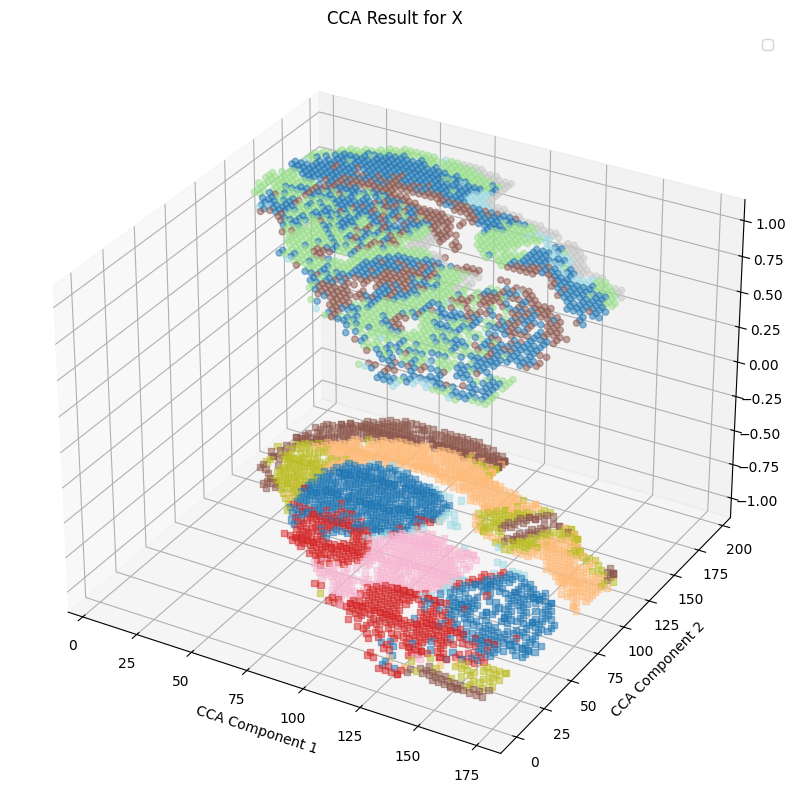

In [242]:
Y_c = G
Z_c = data3_spatial_results
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

In [243]:
pairs

spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  \
0        137.817923     125.340372           0                1   
1         21.572302     146.200189           1                5   
2        121.629176      29.851709           2                2   
3        154.054815     110.450999           3                1   
4         32.434633     101.483139           4                5   
...             ...            ...         ...              ...   
2215     100.003691      74.621137        2215                4   
2216      54.061437     143.277590        2216                0   
2217      37.814902     149.234820        2217                1   
2218      32.371114     110.414016        2218                5   
2219      54.052989     182.066531        2219                3   

      spatial.CCA.Z  metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  \
0                -1       137.837838       125.373134          2068   
1                -1        21.621622       146.268657          2496   
2                -1       121.621622        29.850746           316   
3                -1       154.054054       110.447761          1754   
4                -1        32.432432       101.492537          1616   
...             ...              ...              ...           ...   
2215             -1       100.000000        74.626866          1059   
2216             -1        54.054054       143.283582          2432   
2217             -1        37.837838       149.253731          2541   
2218             -1        32.432432       110.447761          1799   
2219             -1        54.054054       182.089552          2947   

      matabolic_cluster  matabolic.CCA.Z  
0                     3                1  
1                     1                1  
2                     2                1  
3                     1                1  
4                     1                1  
...                 ...              ...  
2215                  3                1  
2216                  1                1  
2217                  3                1  
2218                  2                1  
2219                  1                1  

[2220 rows x 10 columns]

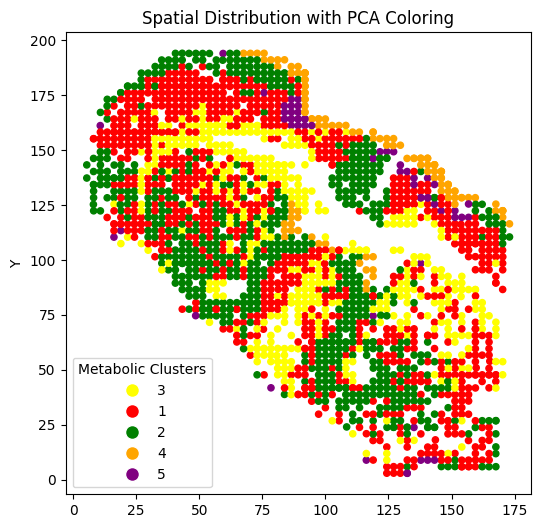

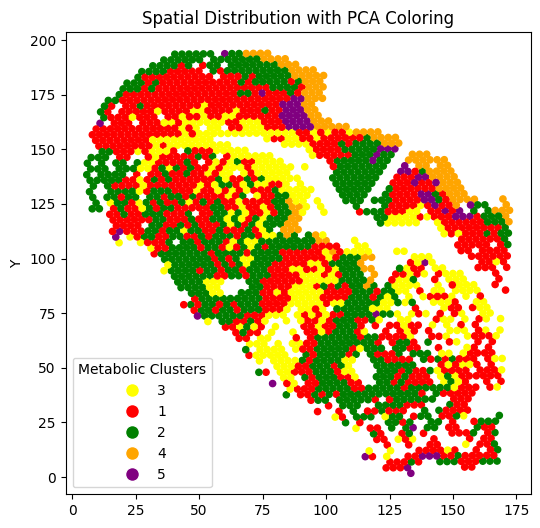

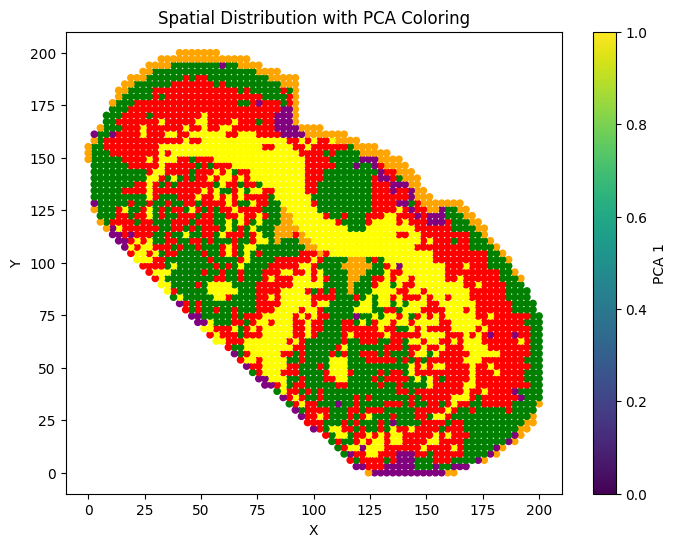

In [244]:
plt.figure(figsize=(6, 6))
plt.scatter(G.iloc[:, 0],G.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\anchor_merge_nearst_pair_after_SVD.pdf")
plt.show()
plt.figure(figsize=(6, 6))

plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\with_anchor_merge_nearst_pair_before_SVD.pdf")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [249]:
result_df.to_csv("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\result_groundtruth.csv", index=False)